In [2]:
import evaluation.score_acculumator as score_accumulator
import evaluation.plotting_utils as plot_utils
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm
import json, os, sys


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" # change this to change gpu number

import torch
print(torch.cuda.get_device_name(torch.cuda.current_device()))

%load_ext autoreload
%autoreload 2

NVIDIA TITAN Xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Embedding similarity analysis

Run the following code segments to generate an similarity analysis of full-song embeddings. The embeddings require access to a gpu to run at a reasonable speed.

In [4]:
########### Download the model and read in the prediction data ########

model = SentenceTransformer('all-mpnet-base-v2')
finetuned_path = "predictions/test_song_generations.json"
basemodel_path = "predictions/test_song_generations_based_model.json"

finetuned = pd.read_json(finetuned_path, orient="records")
finetuned = finetuned['model_response'].to_list()

basemodel = pd.read_json(basemodel_path, orient="records")
basemodel = basemodel['model_response'].to_list()

ground_truth =  pd.read_json(basemodel_path, orient="records")['target_response'].to_list()

In [6]:
########### Compute embeddings for each prediction and the ground truth ########
lyre_embed = [model.encode(song) for song in tqdm(finetuned, 'Lyre embeddings')]
llama_embed = [model.encode(song) for song in tqdm(basemodel, 'Llama embeddings')]
target_embed = [model.encode(song) for song in tqdm(ground_truth, 'Target embeddings')]

norm = lambda x: x / np.linalg.norm(x)
base_score, finetuned_score = np.zeros((len(llama_embed,))), np.zeros((len(lyre_embed,)))
for i in range(len(llama_embed)):
    base_score[i] = np.dot(norm(llama_embed[i]), norm(target_embed[i]))
    finetuned_score[i] = np.dot(norm(lyre_embed[i]), norm(target_embed[i]))

Target embeddings: 100%|██████████| 681/681 [00:17<00:00, 37.84it/s]


In [7]:
print(f"Lyre similarity score: {np.mean(finetuned_score)}")
print(f"Llama similarity score: {np.mean(base_score)}")

Lyre similarity score: 0.659688838384225
Llama similarity score: 0.6418222863987504


# PCA embeddings analysis
Using the SentenceBert embeddings, we can also analyze our model similarities in 3D space via PCA. Use the parameter `cp_offset` to sample different principal component windows, and highlight the differences between the finetuned and the Llama model outputs.

In [11]:
colors = ['darkseagreen', 'lightcoral', 'mediumorchid'] 
labels = ["Ground Truth", "Lyre Outputs", "Llama Outputs"]

# Compute 10-component PCA
comp = PCA(n_components=10)
pc_offset = 3

# Transform embeddings
top1 = comp.fit_transform(np.stack(target_embed, 0))[:, pc_offset:pc_offset+3]
top2 = comp.transform(np.stack(lyre_embed, 0))[:, pc_offset:pc_offset+3]
top3 = comp.transform(np.stack(llama_embed, 0))[:, pc_offset:pc_offset+3]

plot_utils.plot_3d_pca([top1, top2, top3], labels, colors)

# Musical Structure Analysis
As per section 2.1 of our report, we can evaluate the musical & structural qualities of the finetuned Lyre model's predictions.
We analyze 8 different metrics. For more detail, refer to our report, or take a look at the code under [scoring_metrics.py](evaluation/scoring_metrics.py)

The following lines may take a while, especially if you don't have a powerful GPU. 

Consider **skipping to the next section**, and loading the saved results of the evaluation.

In [194]:
measures = ["diversity", "syllable", "meter", "semantics", "semantics_internal", "string_similarity", "tail_similarity", "head_similarity", "phonetics"]

In [195]:
########## Define accumulators and run metric analysis #######
lyre_accumulator = score_accumulator.ScoreAccumulator(measures)
lyre_db_path = "predictions/test_song_generations.json"

llama_accumulator = score_accumulator.ScoreAccumulator(measures)
llama_db_path = "predictions/test_song_generations_based_model.json"

with open(lyre_db_path, 'r') as f:
    lyre_database = json.load(f)
lyre_accumulator.score_all_songs(lyre_database, num_workers=8)

with open(llama_db_path, 'r') as f:
    llama_database = json.load(f)
llama_accumulator.score_all_songs(llama_database)

 59%|█████▉    | 405/681 [03:17<01:53,  2.43it/s]

Error processing song: 405 Stanza keywords are too complex, please simplify


  2%|▏         | 12/681 [00:05<06:19,  1.76it/s]

Model refused song 12 for value alignment reasons.


  2%|▏         | 17/681 [00:06<04:38,  2.38it/s]

Model refused song 17 for value alignment reasons.


  3%|▎         | 19/681 [00:07<03:02,  3.63it/s]

Model refused song 19 for value alignment reasons.
Model refused song 20 for value alignment reasons.


  4%|▎         | 25/681 [00:08<03:05,  3.54it/s]

Model refused song 25 for value alignment reasons.


  6%|▌         | 42/681 [00:13<03:37,  2.93it/s]

Model refused song 42 for value alignment reasons.


  7%|▋         | 50/681 [00:16<04:22,  2.40it/s]

Model refused song 50 for value alignment reasons.


 10%|▉         | 65/681 [00:21<03:40,  2.79it/s]

Model refused song 65 for value alignment reasons.


 10%|█         | 70/681 [00:22<02:51,  3.56it/s]

Model refused song 70 for value alignment reasons.


 16%|█▌        | 106/681 [00:36<04:18,  2.22it/s]

Model refused song 106 for value alignment reasons.


 16%|█▋        | 111/681 [00:37<02:23,  3.98it/s]

Model refused song 111 for value alignment reasons.


 24%|██▎       | 161/681 [01:07<03:02,  2.86it/s]

Model refused song 161 for value alignment reasons.


 25%|██▍       | 169/681 [01:10<02:47,  3.05it/s]

Model refused song 169 for value alignment reasons.


 28%|██▊       | 194/681 [01:19<02:38,  3.07it/s]

Model refused song 194 for value alignment reasons.


 30%|██▉       | 203/681 [01:21<02:25,  3.28it/s]

Model refused song 203 for value alignment reasons.


 34%|███▍      | 233/681 [01:33<03:11,  2.34it/s]

Model refused song 233 for value alignment reasons.


 43%|████▎     | 292/681 [01:56<02:34,  2.52it/s]

Model refused song 292 for value alignment reasons.


 53%|█████▎    | 359/681 [02:22<01:13,  4.39it/s]

Model refused song 359 for value alignment reasons.
Model refused song 360 for value alignment reasons.


 53%|█████▎    | 362/681 [02:22<00:53,  5.96it/s]

Model refused song 362 for value alignment reasons.


 57%|█████▋    | 391/681 [02:33<01:48,  2.68it/s]

Model refused song 391 for value alignment reasons.


 59%|█████▉    | 405/681 [02:37<01:36,  2.86it/s]

Error processing song: 405 Stanza keywords are too complex, please simplify


 63%|██████▎   | 430/681 [02:48<01:29,  2.80it/s]

Model refused song 430 for value alignment reasons.


 64%|██████▍   | 439/681 [02:50<01:20,  2.99it/s]

Model refused song 439 for value alignment reasons.


 67%|██████▋   | 457/681 [02:56<01:34,  2.36it/s]

Model refused song 457 for value alignment reasons.


 68%|██████▊   | 464/681 [02:58<01:15,  2.86it/s]

Model refused song 464 for value alignment reasons.


 80%|████████  | 546/681 [03:30<00:44,  3.02it/s]

Model refused song 546 for value alignment reasons.
Model refused song 547 for value alignment reasons.


 84%|████████▍ | 571/681 [03:39<00:43,  2.53it/s]

Model refused song 571 for value alignment reasons.


 96%|█████████▌| 651/681 [04:12<00:14,  2.14it/s]

Model refused song 651 for value alignment reasons.


100%|██████████| 681/681 [04:22<00:00,  2.60it/s]


You may notice that llama has rejected some of the prompts due to its value alignment. To generate a fair comparison, we will prune these from the lyre outputs.

In [196]:
########### Prune mismatched song IDs due to value misalignment ##########
lyre_db, llama_db = lyre_accumulator.get_database(), llama_accumulator.get_database()

popped_ids = [[],[]]
for i in range(10000):
    id = i
    if id in llama_db and not id in lyre_db:
        llama_db.pop(id)
        popped_ids[1].append(id)
    elif id in lyre_db and not id in llama_db:
        lyre_db.pop(id)
        popped_ids[0].append(id)
print(f"Removed: {popped_ids[0]} from Lyre, Removed: {popped_ids[1]} from Llama,")

########## Save results ############
out_lyre = "lyre_scores.json"
out_llama = "llama_scores.json"

with open(out_lyre, "w") as f:
    f.write(json.dumps(lyre_db, indent = 2, separators=[",",":"]))

with open(out_llama, "w") as f:
    f.write(json.dumps(llama_db, indent = 2, separators=[",",":"]))

Removed: [12, 17, 19, 20, 25, 42, 50, 65, 70, 106, 111, 161, 169, 194, 203, 233, 292, 359, 360, 362, 391, 430, 439, 457, 464, 546, 547, 571, 651] from Lyre, Removed: [] from Llama,


### Skip here if you don't want to wait for the metrics to run
You can load metrics from a previously run file.

In [197]:
########## Load metric and output databases ###########
with open("lyre_scores.json", 'r') as f:
    lyre_db = json.load(f)
with open("llama_scores.json", 'r') as f:
    llama_db = json.load(f)

In [199]:
########## Collect scores across both databases ###########
lyre_scores = [lyre_db[songid]["pred_scores"] for songid in lyre_db.keys()]
llama_scores = [llama_db[songid]["pred_scores"] for songid in llama_db.keys()]
target_scores = [llama_db[songid]["target_scores"] for songid in llama_db.keys()]

all_scores = {m:{"lyre": [], "llama":[], "target":[]} for m in measures}
for m in measures:
    all_scores[m]["lyre"] = np.array([s[m] for s in lyre_scores])
    all_scores[m]["llama"] = np.array([s[m] for s in llama_scores])
    all_scores[m]["target"] = np.array([s[m] for s in target_scores])



models=["lyre", "llama", "target"]
labels = ["Lyre Outputs", "Llama Outputs", "Ground Truth"]
colors = ['darkseagreen', 'lightcoral', 'mediumorchid'] 

# map between 0 and 100
measure_scales = []
for m in measures:
    for mod in ['lyre', 'llama', 'target']:
        if m != 'diversity':
            all_scores[m][mod] = 100 * np.exp(-all_scores[m][mod])
        else:
            all_scores[m][mod] = 100 * np.exp(all_scores[m][mod])

print(f"Measures available: {'  -  '.join(list(all_scores.keys()))}")

Measures available: diversity  -  syllable  -  meter  -  semantics  -  semantics_internal  -  string_similarity  -  tail_similarity  -  head_similarity  -  phonetics


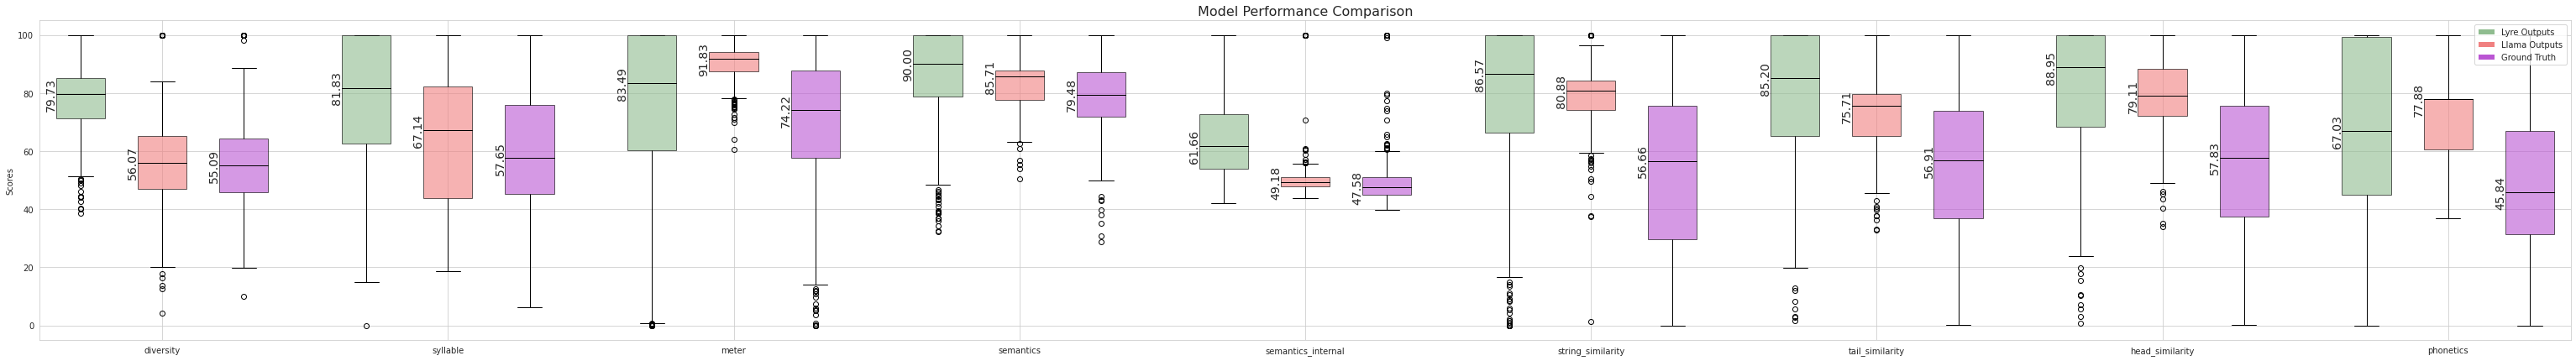

In [209]:
####### Plot measure distributions ########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

plot_utils.measures_boxplot(all_scores, measures_subset, models=models, labels=labels, colors=colors, ylim=None, show_outliers=True)

In [210]:
for m in measures:
    print(f"Measure {m}:")
    print(f"\t Target score: {np.mean(all_scores[m]['target'])}")    
    print(f"\t Lyre score: {np.mean(all_scores[m]['lyre'])}")    
    print(f"\t Llama score: {np.mean(all_scores[m]['llama'])}")    

Measure diversity:
	 Target score: 55.80782424817391
	 Lyre score: 77.47725751667538
	 Llama score: 56.42864989552436
Measure syllable:
	 Target score: 61.57974603043007
	 Lyre score: 78.02079915649595
	 Llama score: 64.75107333654545
Measure meter:
	 Target score: 70.7184461694775
	 Lyre score: 74.43827190972758
	 Llama score: 90.98421180760677
Measure semantics:
	 Target score: 79.53321740390508
	 Lyre score: 85.95967163673133
	 Llama score: 84.51318387404802
Measure semantics_internal:
	 Target score: 50.50269239783452
	 Lyre score: 65.1535931983516
	 Llama score: 51.59456984229473
Measure string_similarity:
	 Target score: 52.60450389339068
	 Lyre score: 79.109626529366
	 Llama score: 80.37863619714132
Measure tail_similarity:
	 Target score: 56.54907603694453
	 Lyre score: 79.35448143285083
	 Llama score: 75.01241728392104
Measure head_similarity:
	 Target score: 57.69079257896001
	 Lyre score: 81.9876840017498
	 Llama score: 79.54005946365774
Measure phonetics:
	 Target score: 50